In [1]:
# initialize inline plotting and load the usual suspects
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
from scipy import signal

In [2]:
def dtft(hh, kk=None, w=None):
    '''Compute the DTFT of signal h
    
    hh - signal samples
    kk - time indices; optional, default: `np.arange(len(hh))`
    ww - frequencies to evaluate; optional, default: np.linspace(-np.pi, np.pi, 512)
    '''
    # check inputs
    if kk is None:
        kk = np.arange(len(hh))
        
    if w is None:
        w = np.linspace(-np.pi, np.pi, 512)
        
    H = np.zeros_like(w, dtype=np.complex)
    
    for h,k in zip(hh, kk):
        H += h * np.exp(-1j*w*k)
        
    return H

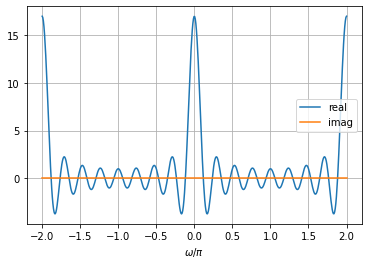

In [3]:
kk = np.arange(-8,9)
w = np.linspace(-2*np.pi, 2*np.pi, 512)

H = dtft(np.ones(17), kk, w)
plt.plot(w/np.pi, H.real)
plt.plot(w/np.pi, H.imag)
plt.legend(['real', 'imag'])
plt.grid()
plt.xlabel('$\omega/\pi$')
plt.show()

# FIR Filter Design

We illustrate two methods for designing a lowpass filter:

* windowing the impulse response of the ideal lowpass filter
* optimal minimax (equiripple) design

For both methods, the concrete filter to be approximated is assumed to have a cut-off frequency equal to $\pi/4$.

In [4]:
wc = np.pi/4

## Filter Design by Windowing

The idea behind filter design by windowing is to approximate the impulse response of the ideal LPF. We know that the ideal LPF has an impulse response that is the inverse DTFT of the rectangular frequency response, i.e.,
$$
    H_{d}(e^{j \omega}) = \left\{ 
    \begin{array}{cl}
    1 & |\omega| \leq \omega_c \\
    0 & \omega_c < |\omega| \leq \pi
    \end{array}
    \right.
$$
Recall that this frequency response is $2\pi$-periodic.

The inverse DTFT yields the impulse response $h_d[n]$
$$
h_d[n] = \frac{1}{2\pi} \int_{-\pi}^{\pi} H_{d}(e^{j \omega}) e^{j\omega n} d\omega = 
         \frac{\sin(\omega_c n)}{\pi n}.
$$
This impulse response has two obstacles that prevent it from being implementable

* it is infinitely long, and
* it is non-causal

If the filter were of finite-duration, then the second problem could be fixed by delaying the impulse response until it is a right-sided signal.

Since we will need a (truncated) version of this impulse response, we make a function that computes samples of $h_d[n]$ between $-L$ and $L$, i.e., of length $2L+1$ samples.

Note: the `sinc` function provided in NumPy (and MATLAB) includes $\pi$, i.e., it is defined as $\text{sinc}(x) = \frac{\sin(\pi x)}{\pi x}$.

In [5]:
def h_d(wc, L):
    '''Generate impulse response of ideal LPF with cutoff wc truncated to 2*L+1 samples
    
    Parameters:
    wc - cutoff frequency
    L - samples range from -L to L, inclusively
    '''
    nn = np.arange(-L,L+1)
    return wc/np.pi*np.sinc(wc/np.pi*nn)

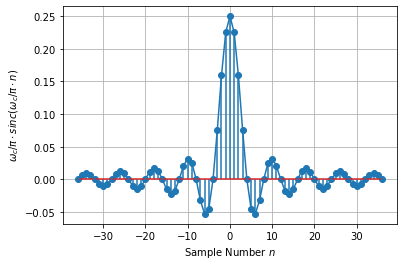

In [6]:
# plot the center segment of the sinc pulse
L = 36
hd = h_d(wc, L)
nn = np.arange(-L,L+1)

plt.stem(nn, hd)
plt.plot(nn, hd)
plt.grid()
plt.xlabel('Sample Number $n$')
plt.ylabel('$\omega_c/\pi \cdot sinc(\omega_c/\pi \cdot n)$')
plt.show()

Note that zeros in the impulse response occur every $\pi/\omega_c = 4$ samples, except at $n=0$. The sidelobes of the sinc-function decay proprtional to $1/n$, i.e., very slowly.

An obvious idea to design a LPF is to simply truncate the ideal impulse response. The parameter $L$ is ideally suited for this purpose. The plot below shows the frequency response of the filters that result from truncation for different values of $L$

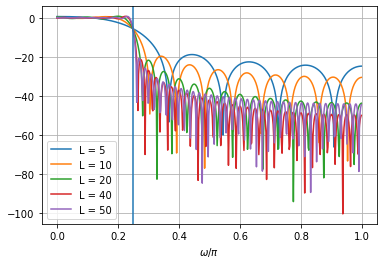

In [7]:
legend_strings = []

for L in [5, 10, 20, 40, 50]:
    hd = h_d(wc, L)
    w, H = signal.freqz(hd, [1])
    
    plt.plot(w/np.pi,20*np.log10(abs(H)))
    legend_strings.append('L = {:d}'.format(L))
    
plt.grid()
plt.axvline(wc/np.pi)
plt.xlabel('$\omega/\pi$')
plt.legend(legend_strings)
plt.show()

**Things to note:**

* The width of the transition band decreases with increasing $L$, i.e., the edge of the filter between passband and stop band becomes sharper with filter order.
* The first sidelobe in the stopband is approximately independent of filter length $2L+1$. For all values of $L$ considered here, the first. sidelobe is at appropximately -20dB.

These properties are -- more or lesss -- directly inherited from the DTFT of a rectangular window of length $2L+1$.
The relationship between the DTFT of the recatangular window stems from the fact that we can view truncation as equivalent to multiplying the infinite ideal impulse response by a rectangular window of length $2L+1$; the window is assumed to be centered over the sinc. Consequently, the DTFT of the truncated sinc (i.e., the frequency response of our first cut at the LPF) is the (periodic) convolution of $H_d(e^{j\omega})$ and the DTFT of the rectangular pulse.

For the rectangular window of length $2L+1$, the DTFT is given by 
$$
    W(e^{j\omega}) = \frac{\sin(\omega(L-\frac{1}{2}))}{\sin(\omega/2)}.
$$
We will compute $W(e^{j\omega})$ using the function `dtft` defined above.


The figure below shows the DTFT of the rectangular pulse for the same values of $L$ as above.

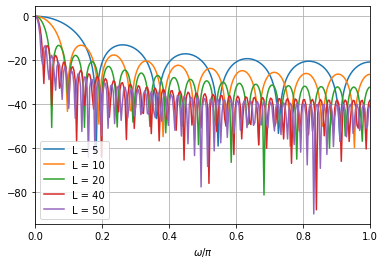

In [8]:
legend_strings = []
kk = np.arange(-L, L+1)
w = np.linspace(-np.pi, np.pi, 512)


for L in [5, 10, 20, 40, 50]:

    # scale so that W(e^{j0}) = 1
    H = dtft(np.ones(2*L+1), kk, w)/(2*L+1)
    
    plt.plot(w/np.pi,20*np.log10(abs(H)))
    legend_strings.append('L = {:d}'.format(L))
    
plt.grid()
plt.xlabel('$\omega/\pi$')
plt.legend(legend_strings)
plt.xlim([0, 1])
plt.show()

Empirically, we can observe that the width of the main lobe of $W(e^{j\omega})$ correlates with the width of the transition band. Also, the first sidelobe is approximately equal to -13dB regradless of the value of $L$.

The resulting filter is not a very good filter.

### Better Windows

The problems with simply truncating the impulse response can be traced back to the fact that the truncation is abrupt. Better frequency domain characteristics, especially in the stop band, can be achieved by gradually tapering the ideal impulse response. A number of windows are well-known to provide a better filter.

We first plot the shape of these windows (for $L=25$, $M=51$).


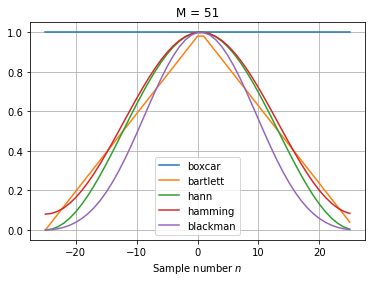

In [9]:
L = 25
M = 2*L+1

legend_strings = []
windows = ['boxcar', 'bartlett', 'hann', 'hamming', 'blackman']
nn = np.arange(-L, L+1)

for win in windows:
    w = signal.get_window(win, M)    
    plt.plot(nn, w)
    legend_strings.append('{:s}'.format(win))
    
plt.grid()
plt.xlabel('Sample number $n$')
plt.legend(legend_strings)
plt.title('M = {:d}'.format(M))
plt.show()

And, then the frequency response of the filter that arises when the ideal impulse reponse is multiplied by the window shape above.

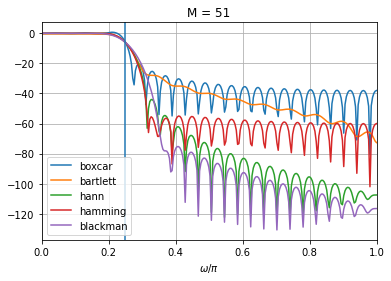

In [10]:
# Frequency Response on log-scale
L = 25
M = 2*L+1

legend_strings = []
kk = np.arange(-L, L+1)
ww = np.linspace(-np.pi, np.pi, 512)

windows = ['boxcar', 'bartlett', 'hann', 'hamming', 'blackman']

for win in windows:
    hd = h_d(wc, L)  # samples of ideal window
    w = signal.get_window(win, M)
    h = hd * w
    
    H = dtft(h, kk, ww)
    
    plt.plot(ww/np.pi,20*np.log10(abs(H)))
    legend_strings.append('{:s}'.format(win))
    
plt.grid()
plt.axvline(wc/np.pi)
plt.xlabel('$\omega/\pi$')
plt.xlim([0, 1])
plt.legend(legend_strings)
plt.title('M = {:d}'.format(M))
plt.show()

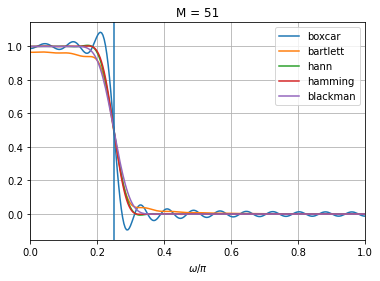

In [11]:
# Frequency response on linear scale
L = 25
M = 2*L+1

legend_strings = []
kk = np.arange(-L, L+1)
ww = np.linspace(-np.pi, np.pi, 512)

windows = ['boxcar', 'bartlett', 'hann', 'hamming', 'blackman']

for win in windows:
    hd = h_d(wc, L)  # samples of ideal window
    w = signal.get_window(win, M)
    h = hd * w
    
    H = dtft(h, kk, ww)
    
    plt.plot(ww/np.pi,np.real(H))
    legend_strings.append('{:s}'.format(win))
    
plt.grid()
plt.axvline(wc/np.pi)
plt.xlabel('$\omega/\pi$')
plt.legend(legend_strings)
plt.xlim([0,1])
plt.title('M = {:d}'.format(M))
plt.show()

**Things to note:**

* The rectangular window transitions fastest from pass band to stop band, but it has the poorest stopband performance - by far.
* The other windows transition more slowly initially but have a much better stop band performance.
* On the linear scale, we can see that all frequency response are equal to $\frac{1}{2}$ at $\omega=\omega_c$.
* Also on the linear scale, it is apparent that the stp band ripple equals the passband ripple - they cannot be independently controlled.
* Finally, the stopband ripple decreases with frequency. More accurately, the ripple is largest closest to the band edge.

In summary, while better filters result when we use windows to taper the ideal impulse response, these filters are still not great. Moreover, the only design parameter is the filter length which affects primarily the width of the transition band.

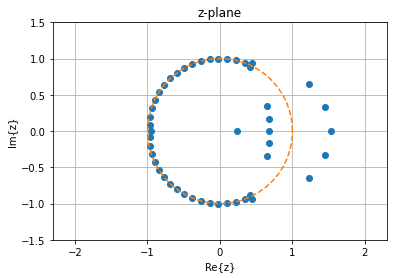

In [12]:
# plot the zeros of filter from blackman window
L = 25
M = 2*L+1
win = 'blackman'

hd = h_d(wc, L)  # samples of ideal window
w = signal.get_window(win, M)
h = hd * w

z = np.roots(h)

plt.plot(z.real, z.imag, 'o')
plt.plot(np.cos(np.linspace(0, 2*np.pi)), np.sin(np.linspace(0,2*np.pi)),'--')
plt.xlabel('Re{z}')
plt.ylabel('Im{z}')
plt.title('z-plane')

# there appear to be additional zeros near +/-j ininity, manually set axis limits
# to focus on unit circle
plt.axis('equal')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])


plt.grid()
plt.show()

## Minimax, Optimal Design - The Parks-McLellan Algorithm

The shortcomings identified above are overcome by designing filters using the Parks-McLellan algorithm. It was invented in 1973 and relied on a polynomial approximation algorithm known as the Remez Exchange Algorithm. This has become the most widely used algrithm for designing very good FIR filters. Implementations are available in 

* Matlab - function `firpm`
* NumPy/SciPy - function `remez`

To use these filter design functions, the filter specifications must be provided. This happens generally via parameters like the following (for the `remez`) function

* N - The desired number of taps in the filter. The number of taps is the number of terms in the filter, or the filter order plus one.
* bands - A monotonic sequence containing the band edges. All elements must be non-negative and less than half the sampling frequency as given by fs.
* desired - A sequence half the size of bands containing the desired gain in each of the specified bands.
* weight (optional) - A relative weighting to give to each band region. The length of weight has to be half the length of bands.

For example, our lowpass filter with passbane $\omega_p=\pi(1/4-1/32)$ and stop band edge $\omega_p=\pi(1/4+1/32)$ and length $M=51$ would be designed as follows

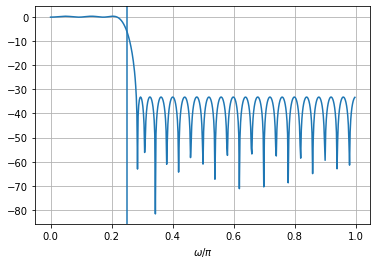

In [13]:
M = 51
bands = np.array([0, np.pi*(1/4-1/32), np.pi*(1/4+1/32), np.pi])/(2*np.pi)
desired = [1, 0]
weight = [1, 1]  # equal weight

h = signal.remez(M, bands, desired, weight)

w, H = signal.freqz(h, [1])
plt.plot(w/np.pi,20*np.log10(abs(H)))
    
plt.grid()
plt.axvline(wc/np.pi)
plt.xlabel('$\omega/\pi$')
plt.show()

It is readily apparent that the ripple in both the passband and the stopband is uniform - that is the explicit objective of the Parks-McLellan algorithm. Moreover, even this relatively short filter achieves more than 30 dB stop band attenuation. The stopband performance can be improved by one or all of the following

* increase the filter length $M$
* Increase the weight assigned to the stop band
* Increase the width of the transition band $\omega_s-\omega_p$

The impulse response of this filter retains some of the characteristics of the truncated sinc function.

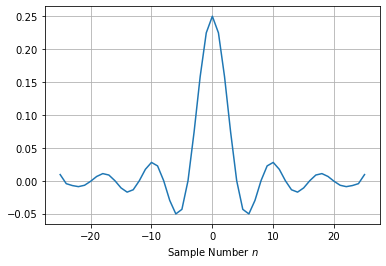

In [14]:
kk = np.arange(-25,26)
plt.plot(kk, h)

plt.grid()
plt.xlabel('Sample Number $n$')
plt.show()

Let's also take a look at the location of the zeros in the z-plane; this filter has $M-1=50$ zeros. This being an FIR filter, there are $M-1=50$ poles at the origin.

In the plot below, we see that the pass band is formed by a "channel" formed by pairs of zeros that are reflected at the unit circle. recall that this is needed to ensure constant group delay. The stop band is formed by (approximately) uniformly spaced zeros on the unit circle.

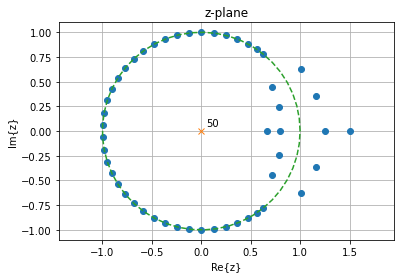

In [15]:
z = np.roots(h)

plt.plot(z.real, z.imag, 'o')
plt.plot(0, 0, 'x')
plt.text(0.05, 0.05, '{:d}'.format(M-1))
plt.plot(np.cos(np.linspace(0, 2*np.pi)), np.sin(np.linspace(0,2*np.pi)),'--')
plt.xlabel('Re{z}')
plt.ylabel('Im{z}')
plt.title('z-plane')

plt.axis('equal')
plt.grid()
plt.show()

To consider the impact of the filter length, we compare the frequency reponse of differnt length filters with otherwise identical specifications.

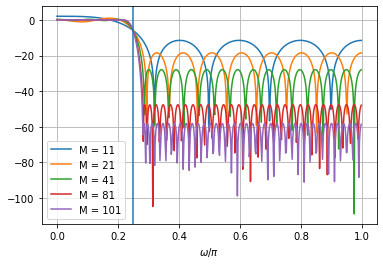

In [16]:
legend_strings = []
bands = np.array([0, np.pi*(1/4-1/32), np.pi*(1/4+1/32), np.pi])/(2*np.pi)
desired = [1, 0]
weight = [1, 1]  # equal weight


for L in [5, 10, 20, 40, 50]:
    M = 2*L+1
    h = signal.remez(M, bands, desired, weight)
    w, H = signal.freqz(h, [1])
    
    plt.plot(w/np.pi,20*np.log10(abs(H)))
    legend_strings.append('M = {:d}'.format(2*L+1))
    
plt.grid()
plt.axvline(wc/np.pi)
plt.xlabel('$\omega/\pi$')
plt.legend(legend_strings)
plt.show()

Similarly, we can study the impact of the weight on the filter for a fixed length $M=51$. Specifically, we fix the weight in the passband and vary the weight for the stop band

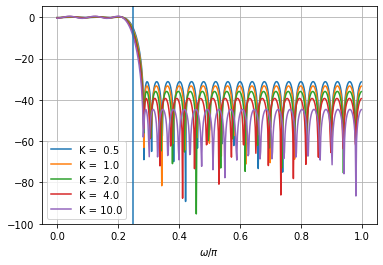

In [17]:
legend_strings = []
bands = np.array([0, np.pi*(1/4-1/32), np.pi*(1/4+1/32), np.pi])/(2*np.pi)
desired = [1, 0]
M = 51

for K in [0.5, 1, 2, 4, 10]:
    weight = [1, K]  

    h = signal.remez(M, bands, desired, weight)
    w, H = signal.freqz(h, [1])
    
    plt.plot(w/np.pi,20*np.log10(abs(H)))
    legend_strings.append('K = {:4.1f}'.format(K))
    
plt.grid()
plt.axvline(wc/np.pi)
plt.xlabel('$\omega/\pi$')
plt.legend(legend_strings)
plt.show()

### Estimating Required Filter Length

It is not straightforward to know how long a filter is needed to achieve given filter specifications in terms of 

* pass band edge $\omega_p$
* stopband edge $\omega_s$
* passband ripple $\delta_1$
* stopband ripple $\delta_s$

However, two useful "rules-of-thumb" exist to determine the required filter order.

The first is due to Harris
$$
    M \approx \frac{20 \log_{10}(\delta_s)}{22} \cdot \frac{2\pi}{\Delta \omega},
$$
where $\Delta \omega = \omega_s - \omega_p$.

The second is due to Kaiser; it is a refinement over the above:
$$
M \approx \frac{10 \log_{10}(\delta_1 \delta_s)-13}{14.6} \cdot \frac{2\pi}{\Delta \omega}
$$
